In [21]:
import os

import librosa, librosa.display
import IPython.display as ipd
from random import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras

from scipy import signal
from sklearn.model_selection import train_test_split
from tqdm import tqdm

PROCESSED_DATA_PICKLE_PATH = '../data/df_all_aug.pkl'

EMOTIONS = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

MFCC_LENGTH = 125


In [22]:
def load_data(data_path):
    df = pd.read_pickle(data_path)

    # clean up data
    vals = []
    for i, val in enumerate(df["mfcc"].to_numpy()):
        if len(val) < MFCC_LENGTH:
            vals.append(i)

    df = df.drop(vals)
    df = df.reset_index(drop=True)

    df_train = df[df["usage"] == "train"]
    df_test = df[df["usage"] == "test"]

    X_train = np.stack(df_train["mfcc"].to_numpy())
    X_test = np.stack(df_test["mfcc"].to_numpy())
    y_train = np.stack(df_train["emotion"].to_numpy())
    y_test = np.stack(df_test["emotion"].to_numpy())

    return X_train, X_test, y_train, y_test

In [23]:
def prepare_datasets(validation_size):

    # create train/test split
    X_train, X_test, y_train, y_test = load_data(PROCESSED_DATA_PICKLE_PATH)

    # create train/validation split
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # 3d array -> (130, 13, 1)
    X_train = X_train[..., np.newaxis] # 4d array -> (number_samples, 130, 13, 1)
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test

X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.2)

In [24]:
def build_model(input_shape):

    # create model
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPool2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten the output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(8, activation='softmax'))

    return model

input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
model = build_model(input_shape)

# compile network
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.summary()

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_validation, y_validation),
    epochs=30,
    batch_size=16
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 123, 11, 32)       320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 62, 6, 32)         0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 62, 6, 32)         128       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 60, 4, 32)         9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 2, 32)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 30, 2, 32)         128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 29, 1, 32)        

In [25]:
# evaluate the CNN on the test set
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy on test set is: {}".format(test_accuracy))

def predict(model, X, y):

    X = X[np.newaxis, ...]

    # prediction = [ [0.1, 0.2, ...] ]
    prediction = model.predict_classes(X)[0] # X -> (130, 13, 1)

    print("Expected Emotion: {}, Predicted Emotion: {}".format(EMOTIONS[y], EMOTIONS[prediction]))


# make prediction on a sample
X = X_test[123]
y = y_test[123]
predict(model, X, y)

288/288 [==============================] - 0s 587us/sample - loss: 1.1392 - accuracy: 0.6007
Accuracy on test set is: 0.6006944179534912
Expected Emotion: angry, Predicted Emotion: surprised


In [26]:
def plot_history(history):

    fig, axs = plt.subplots(2)

    # create accuracy subplot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error subplot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

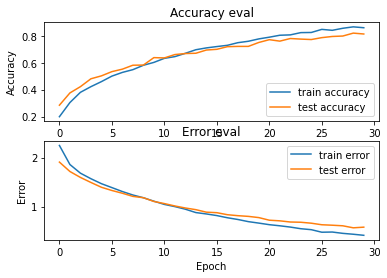

In [27]:
plot_history(history)